In [1]:
import numpy as np
from scipy.fft import rfft2, irfft2, fftshift
from numpy import log
import pathlib
%matplotlib inline
import matplotlib.pyplot as plt

import openpiv.tools as pivtools
import openpiv.scaling as pivscaling
import openpiv.filters as pivfilters
import openpiv.preprocess as pivpre
import openpiv.validation as pivval
from openpiv.tools import imread
from openpiv.pyprocess import (
    extended_search_area_piv,
    normalize_intensity,
    get_coordinates,
)
from PIL import Image


In [2]:
# C:\Users\adamk\Projects\slope-finder\img\piv\4238_1224.tif
frame_a = Image.open("../img/piv/4238_1224.tif")
frame_b = Image.open("../img/piv/4238_1228.tif")

# test
frame_a = np.array(frame_a)
frame_b = np.array(frame_b)

frame_a = normalize_intensity(frame_a)
frame_b = normalize_intensity(frame_b)


In [3]:
window_size = 32
overlap = 16
dt = 4 * (1.0 / 200) #skiped frames * s/fps
search_area_size = 32
correlation_method = "linear"
subpixel_method = "gaussian"
sig2noise_method = "peak2peak"

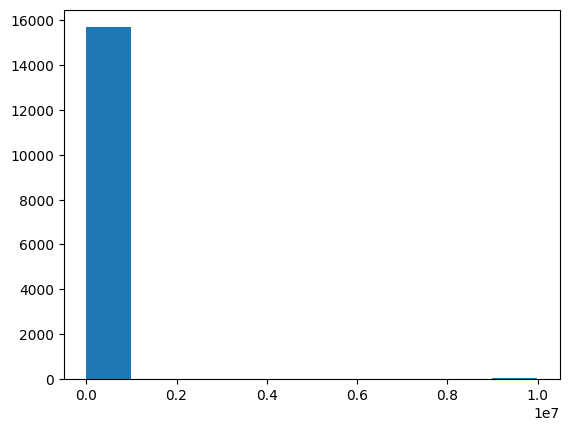

In [4]:
u0, v0, sig2noise = extended_search_area_piv(
    frame_a,
    frame_b,
    window_size=window_size,
    search_area_size=search_area_size,
    overlap=overlap,
    dt=dt,
    correlation_method=correlation_method,
    normalized_correlation=True,
    subpixel_method=subpixel_method,
    sig2noise_method=sig2noise_method,
)

# print(u0[100:110])

x, y = get_coordinates(
    image_size=frame_a.shape,
    search_area_size=search_area_size,
    overlap=overlap,
)

plt.hist(sig2noise.flatten())

invalid_mask = pivval.sig2noise_val(
    sig2noise,
    threshold=1,
)

In [5]:
u2, v2 = pivfilters.replace_outliers(
    u0,
    v0,
    invalid_mask,
    method="localmean",
    max_iter=3,
    kernel_size=3,
)

xs, ys, u3, v3 = pivscaling.uniform(
    x,
    y,
    u2,
    v2,
    scaling_factor=4.75,  # 96.52 pixels/millimeter 238/5 px/cm =
)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
xs, ys, u3, v3 = pivtools.transform_coordinates(xs, ys, u2, v2)

pivtools.save("../config/exp1_001.txt", xs, ys, u3, v3, invalid_mask)


(99, 159)


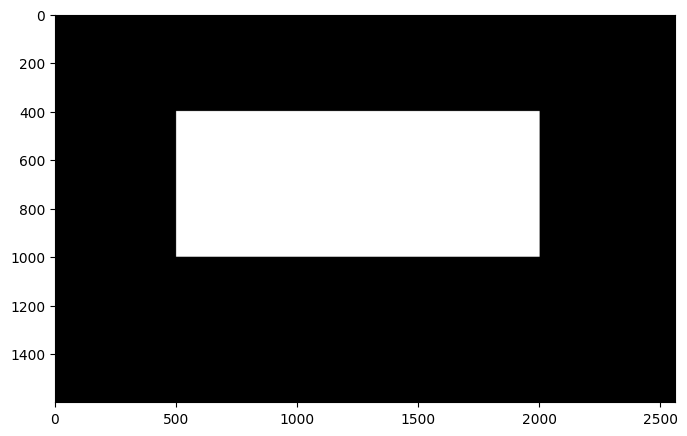

In [6]:
from skimage.draw import polygon 
fig,ax=plt.subplots(figsize=(8,8)) 
img=0*frame_a.copy() 
x1 = 400
x2 = 1000
y1 = 500
y2 = 2000
rr,cc=polygon([x1,x2,x2,x1],[y1,y1,y2,y2]) 
img[rr,cc]=1 
ax.imshow(img,cmap='gray')
img=np.where(img,False,True)
grid_mask=pivpre.prepare_mask_on_grid(x,y,img)

masked_u=np.ma.masked_array(u3,mask=grid_mask) 
masked_v=np.ma.masked_array(v3,mask=grid_mask)
print(np.shape(masked_u))


In [7]:
import PyQt6

(99, 159)


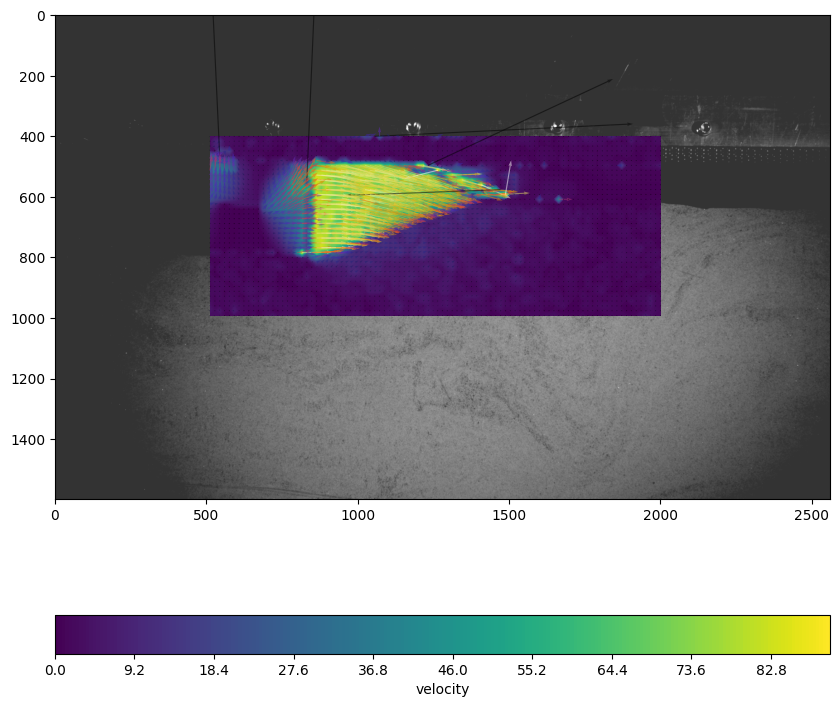

In [8]:
fig, ax= plt.subplots(figsize=(10,10))
ax.imshow(frame_a,alpha=.8,cmap='gray',origin='lower') 
vel_mag = np.sqrt(np.abs(masked_u**2 + masked_v**2))
vel_mag[vel_mag > 120 ] = 0
# v_mask = np.where(img,False,True)
vorticity = (v3 / x + u3 / y)
vorticity[vorticity < 0] = 0
vorticity[vorticity > 2] = 0
print(np.shape(vel_mag))
C = ax.contourf(x, y, vel_mag, 255)
Q= ax.quiver(x, y, masked_u,-masked_v, vel_mag, alpha=0.5, scale=2000, cmap="CMRmap", width=0.0015) 
#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
ax.invert_yaxis() 
cb=fig.colorbar(C,orientation='horizontal') 
cb.set_label('velocity')
# %matplotlib notebook



np.shape(u3)=(99, 159)
np.shape(v3)=(99, 159)


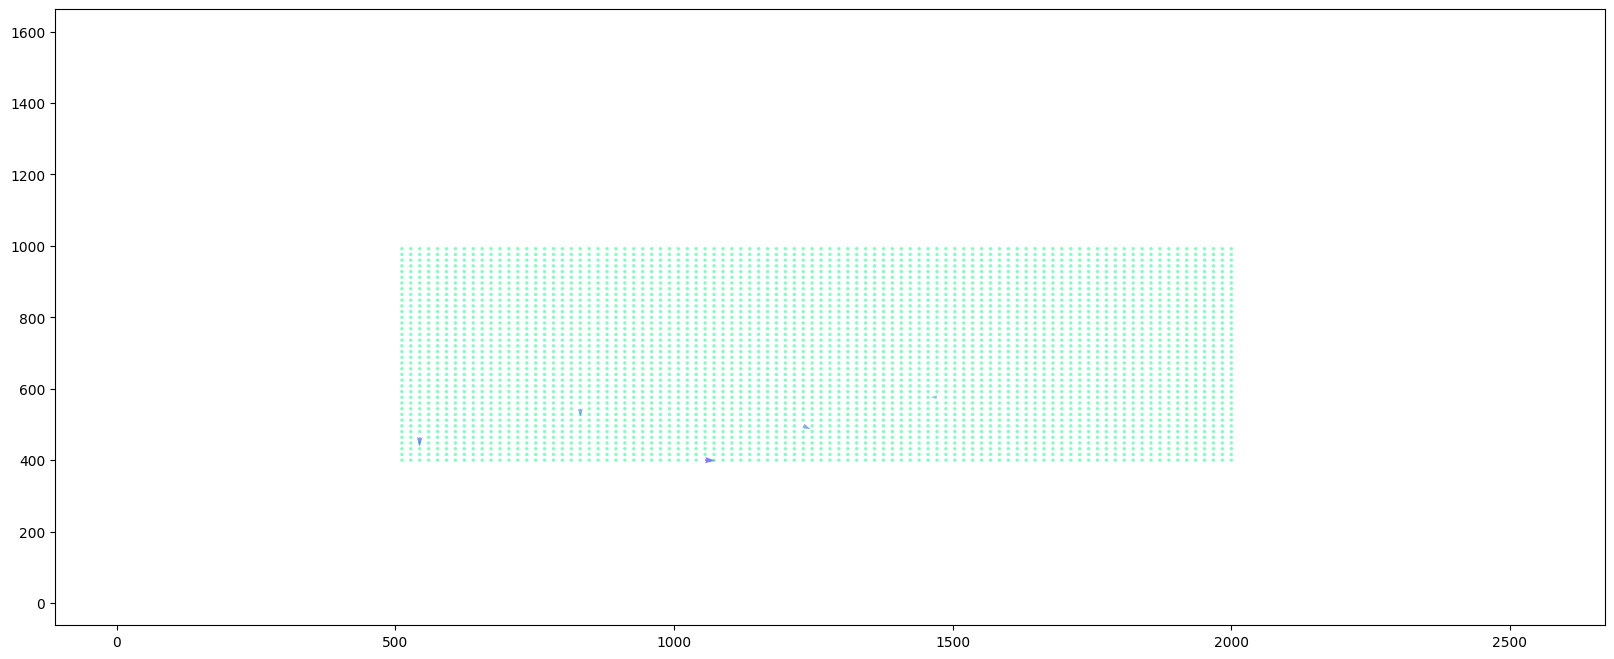

In [9]:


# vorticity_filtered = vorticity
print(f"{np.shape(u3)=}")
print(f"{np.shape(v3)=}")

plt.figure(figsize=(20, 8))
# cp = plt.contourf(u3, v3, vorticity)
# cb = plt.colorbar(cp)
# masked_u=np.ma.masked_array(u3,mask=grid_mask) 
# masked_v=np.ma.masked_array(v3,mask=grid_mask)
Q = plt.quiver(x, y, masked_u, masked_v, u3**2+v3**2, scale=100000, alpha=0.5, cmap="winter_r")
# plt.scatter(x, y, u3, marker="s")
# cb=fig.colorbar(Q,orientation='horizontal') cb.set_label('velocity')

plt.show()


# Vectors with quiverplt.imshow(phi, extent=(0,10,0,10), interpolation='none', origin='lower')plt.quiver(x, y, np.gradient(phi)[0], np.gradient(phi)[1])


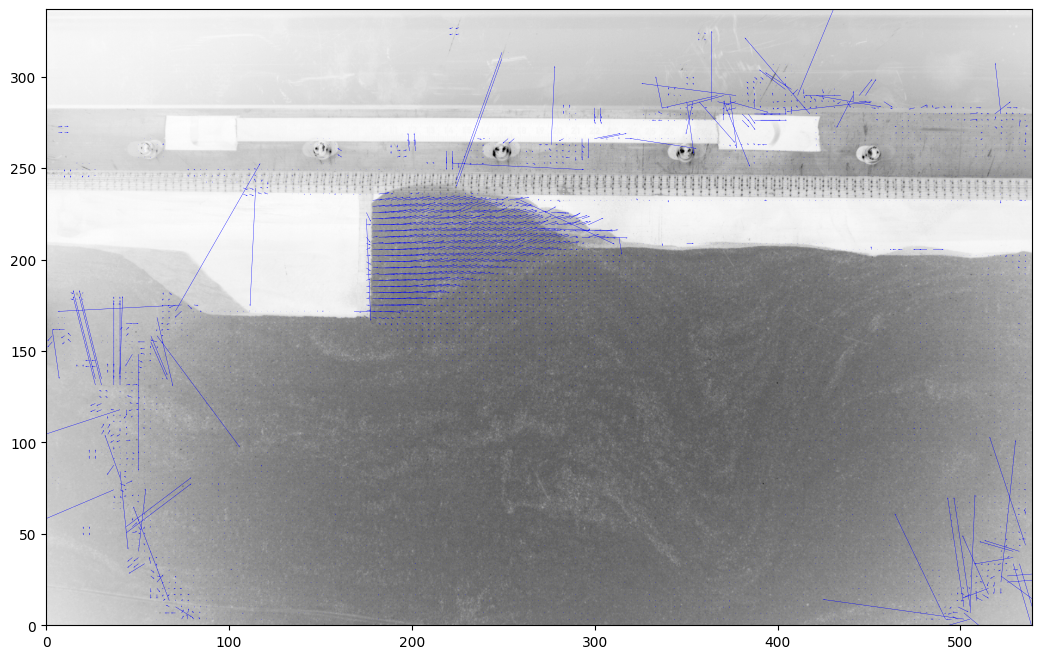

(<Figure size 2000x800 with 1 Axes>, <Axes: >)

In [10]:
fig, ax = plt.subplots(figsize=(20, 8))
pivtools.display_vector_field(
    pathlib.Path("../config/exp1_001.txt"),
    ax=ax,
    scaling_factor=4.75,
    scale=5000,  # scale defines here the arrow length
    width=0.00035,  # width is the thickness of the arrow
    on_img=True,  # overlay on the image
    image_name="../img/piv/4238_1224.tif",
    show_invalid=False,
)
